## Part 1. Logistic regression by IRLS

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class Logistic_Regression():
    def __init__(self):
        self.W = []
        self.score = []
        self.accuracy = []
        self.interactions = []

    def sigmoid(self, X, W):
        return 1 / (1 + np.exp(-X @ W))  # X(n,f) W(f,1)

    def fit(self, X, y, iter=100, eps=1e-2, interactions=[]):
        self.interactions = interactions
        for interaction in interactions:
            X = np.c_[X, X[:, interaction[0] + 1] * X[:, interaction[1] + 1]]
        n, f = X.shape
        W = np.transpose(np.random.uniform(size=f))
        delta  = 1
        i=0

        while i<iter and delta > eps:
            p = self.sigmoid(X,W)
            B = np.diag( p*(1-p) )
            H = np.transpose(X) @ B @ X  # H(f,f)
            grad = np.transpose(X) @ (np.expand_dims(p, axis=1)- np.expand_dims(y, axis=1))
            W_next = np.expand_dims(W, axis=1) - np.linalg.pinv(H) @ grad
            delta = np.linalg.norm(W_next - W)
            W = W_next
            W = W.reshape(-1)
            self.score.append(W)
            i += 1
        self.W = W
        return W

    def predict(self, X, y_true):
        for interaction in self.interactions:
            X = np.c_[X, X[:, interaction[0] + 1] * X[:, interaction[1] + 1]]
        for w in self.score:
            y_pre = ( self.sigmoid(X,w) > 0.5 ).astype(int)
            self.accuracy.append( accuracy_score(y_true, y_pre) )
        return y_pre

## Part 2. Simulation experiments

In [2]:
def dataset1(m=0.5,n=500):
    x11 = np.random.normal(0,1,n)
    x12 = np.random.normal(0,1,n)
    x21 = np.random.normal(m,1,n)
    x22 = np.random.normal(m,1,n)
    X1 = np.vstack( (x11,x12) )
    X2 = np.vstack( (x21,x22) )
    return X1, X2

def dataset2(sigma=0.1 ,n=250):
    x11 = np.random.uniform(-1,1,n)
    x12 = np.sqrt(1-x11*x11)
    x11 = np.hstack( (x11,x11) )
    x12 = np.hstack( (x12,-x12) )
    X1 = np.vstack( (x11,x12) )
    x21 = np.random.uniform(-2,2,n)
    x22 = np.sqrt(4-x21*x21)
    x21 = np.hstack( (x21,x21) )
    x22 = np.hstack( (x22,-x22) )
    X2 = np.vstack( (x21,x22) )
    X1 += np.random.normal(0,sigma,X1.shape)
    X2 += np.random.normal(0,sigma,X2.shape)
    return X1, X2

X1, X2 = dataset1(m=2,n=500)
d1 = np.hstack( (X1,X2) )
Y1 = np.hstack( (np.zeros(X1.shape[1]), np.ones(X2.shape[1])) )

X1, X2 = dataset2(sigma = 0.1,n=250)
d2 = np.hstack( (X1,X2) )
Y2 = np.hstack( (np.ones(X1.shape[1]), np.zeros(X2.shape[1])) )

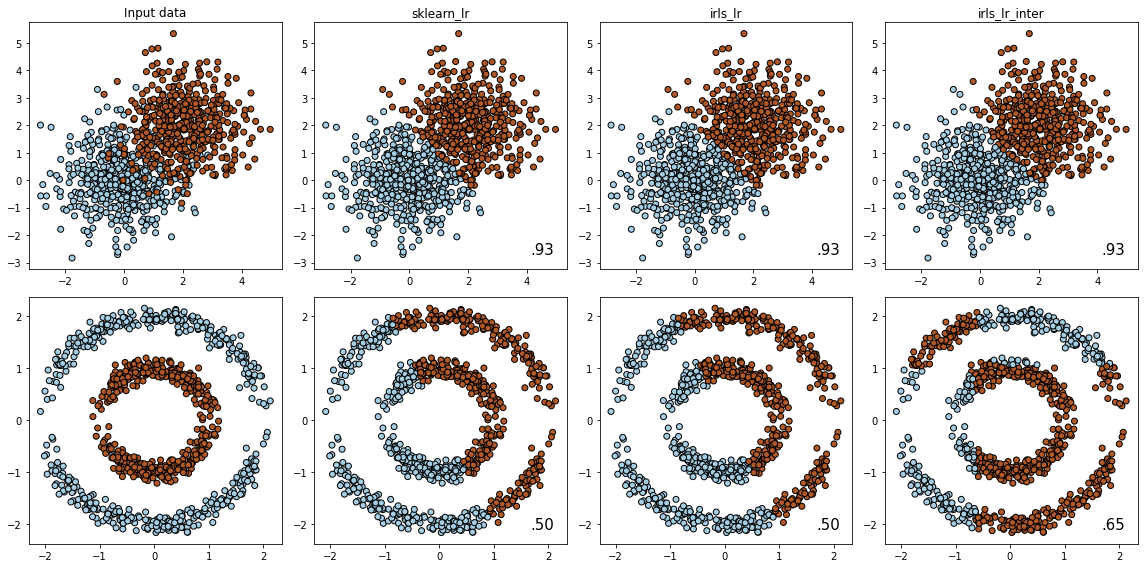

In [17]:
from sklearn.metrics import accuracy_score


# import matplotlib.pyplot as plt
# plt.plot(l)
# plt.show()

def dataset1(m=0.5,n=500):
    x11 = np.random.normal(0,1,n)
    x12 = np.random.normal(0,1,n)
    x21 = np.random.normal(m,1,n)
    x22 = np.random.normal(m,1,n)
    X1 = np.vstack( (x11,x12) )
    X2 = np.vstack( (x21,x22) )
    return X1, X2

def dataset2(sigma=0.1 ,n=250):
    x11 = np.random.uniform(-1,1,n)
    x12 = np.sqrt(1-x11*x11)
    x11 = np.hstack( (x11,x11) )
    x12 = np.hstack( (x12,-x12) )
    X1 = np.vstack( (x11,x12) )
    x21 = np.random.uniform(-2,2,n)
    x22 = np.sqrt(4-x21*x21)
    x21 = np.hstack( (x21,x21) )
    x22 = np.hstack( (x22,-x22) )
    X2 = np.vstack( (x21,x22) )
    X1 += np.random.normal(0,sigma,X1.shape)
    X2 += np.random.normal(0,sigma,X2.shape)
    return X1, X2

X1, X2 = dataset1(m=2,n=500)
d1 = np.hstack( (X1,X2) )
Y1 = np.hstack( (np.zeros(X1.shape[1]), np.ones(X2.shape[1])) )

X1, X2 = dataset2(sigma = 0.1,n=250)
d2 = np.hstack( (X1,X2) )
Y2 = np.hstack( (np.ones(X1.shape[1]), np.zeros(X2.shape[1])) )


from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt

Kernel = ['sklearn_lr','irls_lr', 'irls_lr_inter']
datasets = [(d1,Y1),(d2,Y2)]

nrows = len(datasets)
ncol = len(Kernel) + 1
fig, axes = plt.subplots(nrows,ncol,figsize=(16,8))

for index, (X,Y) in enumerate(datasets):
    X = X.T
    ax = axes[index, 0]
    if index == 0:
        ax.set_title("Input data")
    ax.scatter(X[:,0], X[:,1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k')

    for idx, kernel in enumerate(Kernel):
        ax = axes[index, idx+1]
        
        if kernel == 'sklearn_lr':
            lr = LR()
            lr.fit(X,Y)
            Y_pred = lr.predict(X)
            scored = accuracy_score(Y, Y_pred)
            ax.text(0.95,0.06,('%.2f' % scored).lstrip('0'), size = 15, horizontalalignment='right', transform = ax.transAxes)
            ax.scatter(X[:, 0], X[:, 1], c=Y_pred, zorder=10, cmap=plt.cm.Paired, edgecolor='k')

        if kernel == 'irls_lr':
            irls = Logistic_Regression()
            Xtrain = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
            irls.fit(Xtrain,Y)
            Y_pre = irls.predict(Xtrain,Y)
            score = accuracy_score(Y,Y_pre)
            ax.text(0.95,0.06,('%.2f' % score).lstrip('0'), size = 15, horizontalalignment='right', transform = ax.transAxes)
            ax.scatter(Xtrain[:, 1], Xtrain[:, 2], c=Y_pre, zorder=10, cmap=plt.cm.Paired, edgecolor='k')
            
        if kernel == 'irls_lr_inter':
            irls_in = Logistic_Regression()
            X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
            irls_in.fit(X,Y,interactions=[[0,1]])
            Y_predd = irls_in.predict(X,Y)
            scoredd = accuracy_score(Y,Y_predd)
            ax.text(0.95,0.06,('%.2f' % scoredd).lstrip('0'), size = 15, horizontalalignment='right', transform = ax.transAxes)
            ax.scatter(X[:, 1], X[:, 2], c=Y_predd, zorder=10, cmap=plt.cm.Paired, edgecolor='k')
            
            
        if index == 0:
            ax.set_title(kernel)

        #ax.text(0.95,0.06,('%.2f' % score).lstrip('0'), size = 15, horizontalalignment='right', transform = ax.transAxes)

plt.tight_layout()
plt.show()